In [104]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
import io as IO
from skimage.feature import hog
from skimage import data, color, exposure
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time
import math
import cyvlfeat
# from cyvlfeat import hog
import cv2
import imutils
from pyramid_n_sliding_window import pyramid_score
from skimage import color, morphology

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
leftL_path = '/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/datasets/archive2/lungs/left/'
rightL_path = '/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/datasets/archive2/lungs/right/'
left_lung_imgs = fnmatch.filter(os.listdir(leftL_path), '*.png')
right_lung_imgs = fnmatch.filter(os.listdir(rightL_path), '*.png')

In [3]:
x, y = 500, 500
for i, image_path in enumerate(left_lung_imgs):
    h, w = io.imread(leftL_path+image_path, as_gray=True).shape
    if h<y:
        y=h
    if w<x:
        x=w
dim = (min(y, x), min(y, x))

In [4]:
left_lungs_resized = []
for i, image_path in enumerate(left_lung_imgs):
    img = cv2.imread(leftL_path+image_path, 0)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    left_lungs_resized.append(resized)

In [5]:
right_lungs_resized = []
for i, image_path in enumerate(right_lung_imgs):
    img = cv2.imread(rightL_path+image_path, 0)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    right_lungs_resized.append(resized)

In [6]:
left_lungs_resized[0].shape

(91, 91)

(-0.5, 90.5, 90.5, -0.5)

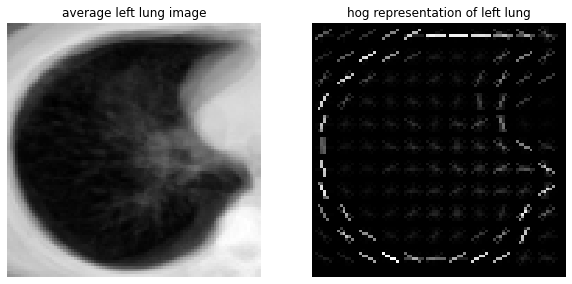

In [7]:
n = len(left_lungs_resized)
LL_shape = left_lungs_resized[0].shape
avg_LL = np.zeros((LL_shape))
for i in left_lungs_resized:
    image = i
    avg_LL = np.asarray(image)+np.asarray(avg_LL)
avg_LL = avg_LL/n

(LL_feature, LL_hog) = hog(avg_LL, visualize=True)

plt.show()
plt.subplot(1,2,1)
plt.imshow(avg_LL)
plt.axis('off')
plt.title('average left lung image')

plt.subplot(1,2,2)
plt.imshow(LL_hog)
plt.title('hog representation of left lung')
plt.axis('off')

In [ ]:
#(LL_feature, face_hog) = hog(avg_LL, cell_size=8, variant='DalalTriggs', bilinear_interpolation=True)

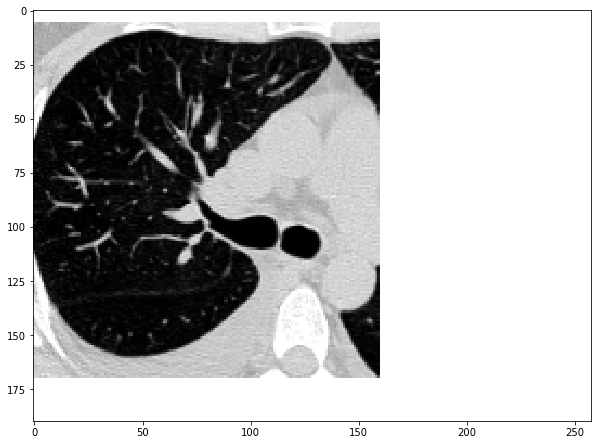

In [129]:
path = '/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/datasets/archive2/COVID/'
# image = cv2.imread(path + 'Covid(1).png', 0)
(winW, winH) = dim

image_one = io.imread(path + 'Covid (77).png', as_gray=True)
# x, y = image_one.shape
# if (x>300) or (y>300):
#     image_one = rescale(image_one, 0.6)


max_score, maxr, maxc, max_scale = pyramid_score(image_one, LL_feature, dim, stepSize = 5, scale=0.9)

fig,ax = plt.subplots()
im = ax.imshow(rescale(image_one, max_scale))
# im = ax.imshow(image_one)
# rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
#ax.add_patch(rect)
winW = winW + winW*max_scale
winH = winH + winH*max_scale
rect = patches.Rectangle((maxc,maxr),winW,winH, transform=ax.transData)
im.set_clip_path(rect)
plt.show()


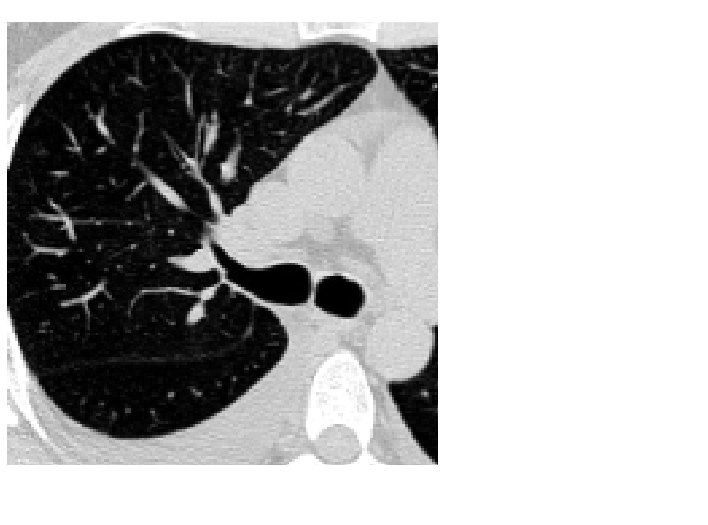

In [155]:
fig,ax = plt.subplots()
im = ax.imshow(rescale(image_one, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH, transform=ax.transData)
#ax.add_patch(rect)
im.set_clip_path(rect)
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()
# data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
fig.savefig('left_mask77_1.png', bbox_inches='tight', format="png",pad_inches=0)

In [105]:
# define a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=180):
    buf = IO.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [131]:
plot_img_np = get_img_from_fig(fig)

In [158]:
from skimage.util import img_as_float
image_1 = img_as_float(cv2.imread('/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/coding/left_mask77_1.png'))


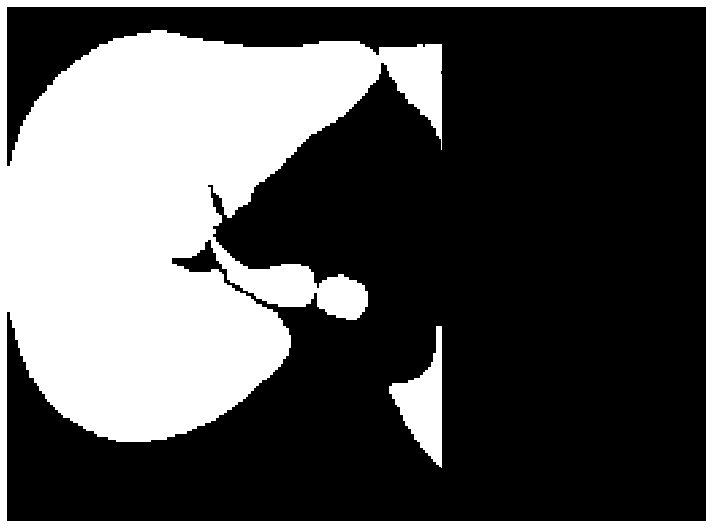

In [160]:
fig,ax = plt.subplots()
lum = color.rgb2gray(image_1)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.6, max(image_1.shape)), max(image_1.shape))
# mask = morphology.opening(mask, morphology.disk(3))

ax.imshow(mask, cmap="gray")
ax.axis('off')
fig.tight_layout()
plt.show()

fig.savefig('left_mask77.png', bbox_inches='tight', format="png",pad_inches=0)
# fig.savefig(buf, format="png", dpi=dpi)

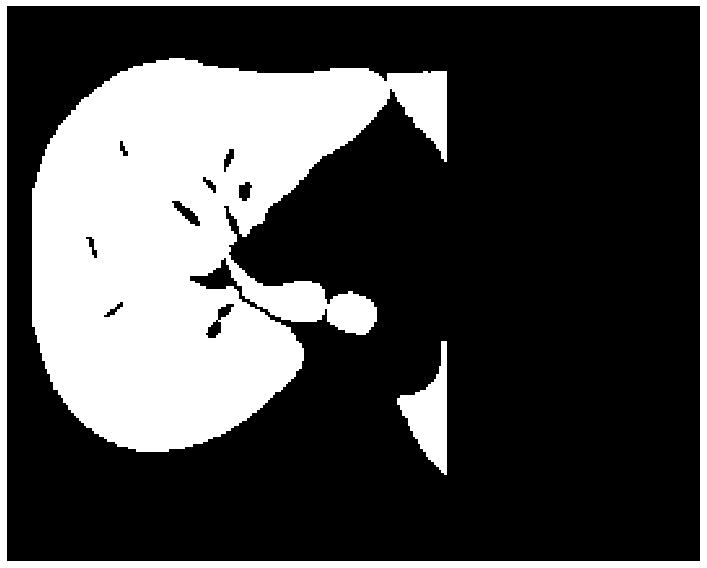

In [150]:
fig,ax = plt.subplots()
lum = color.rgb2gray(plot_img_np)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.6, max(image_one.shape)), max(image_one.shape))
# mask = morphology.opening(mask, morphology.disk(3))

ax.imshow(mask, cmap="gray")
ax.axis('off')
fig.tight_layout()
plt.show()

fig.savefig('left_mask77.png', bbox_inches='tight', format="png",pad_inches=0)
# fig.savefig(buf, format="png", dpi=dpi)

(-0.5, 90.5, 90.5, -0.5)

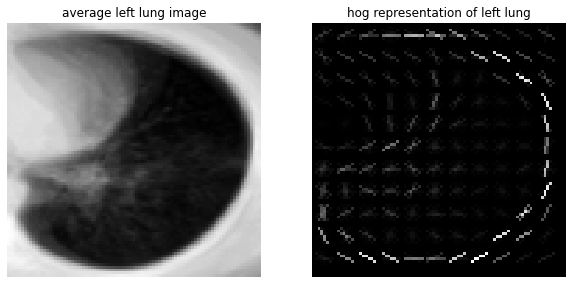

In [43]:
n = len(right_lungs_resized)
RL_shape = right_lungs_resized[0].shape
avg_RL = np.zeros((LL_shape))
for i in right_lungs_resized:
    image = i
    avg_RL = np.asarray(image)+np.asarray(avg_RL)
avg_RL = avg_RL/n

(RL_feature, RL_hog) = hog(avg_RL, visualize=True)

plt.show()
plt.subplot(1,2,1)
plt.imshow(avg_RL)
plt.axis('off')
plt.title('average left lung image')

plt.subplot(1,2,2)
plt.imshow(RL_hog)
plt.title('hog representation of left lung')
plt.axis('off')

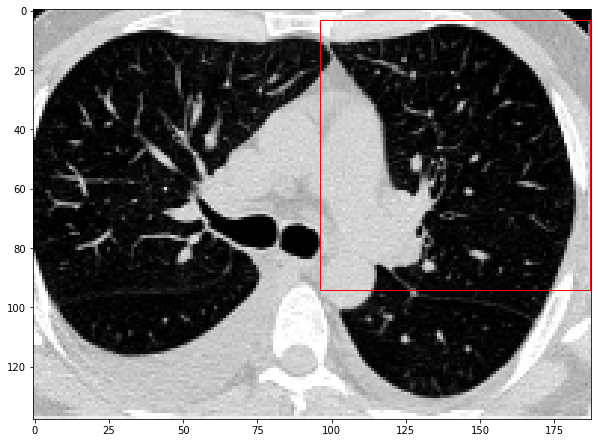

In [57]:
path = '/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/datasets/archive2/COVID/'
# image = cv2.imread(path + 'Covid(1).png', 0)
(winW, winH) = dim

image_one = io.imread(path + 'Covid (77).png', as_gray=True)
x, y = image_one.shape
if (x>300) or (y>300):
    image_one = rescale(image_one, 0.7)


max_score, maxr, maxc, max_scale = pyramid_score(image_one, RL_feature, dim, stepSize = 3, scale=0.9)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image_one, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [58]:
max_scale

0.5904900000000002

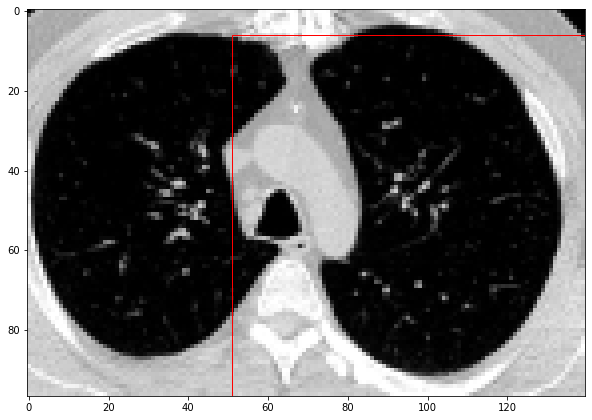

In [65]:
path = '/Users/makhanov/Yandex.Disk.localized/NU-PhD/Fall2020/ComputerVision/project/datasets/archive2/COVID/'
# image = cv2.imread(path + 'Covid(1).png', 0)
(winW, winH) = dim

image_one = io.imread(path + 'Covid (99).png', as_gray=True)
x, y = image_one.shape
if (x>300) or (y>300):
    image_one = rescale(image_one, 0.6)


max_score, maxr, maxc, max_scale = pyramid_score(image_one, RL_feature, dim, stepSize = 3, scale=0.9)

fig,ax = plt.subplots(1)
ax.imshow(rescale(image_one, max_scale))
rect = patches.Rectangle((maxc,maxr),winW,winH,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [67]:
maxr, maxc

(6, 51)

In [ ]:
image = image_one
# image = io.imread(image_path, as_gray=True)
#image = rescale(image, 1.2)

images = pyramid(image, scale = 0.8)
sum_r = 0
sum_c = 0
for i,result in enumerate(images):
    (scale, image) = result
    if (i==0):
        sum_c = image.shape[1]
    sum_r+=image.shape[0]

composite_image = np.zeros((sum_r, sum_c))

pointer = 0
for i, result in enumerate(images):
    (scale, image) = result
    print(image.shape)
    composite_image[pointer:pointer+image.shape[0], :image.shape[1]] = image
    pointer+= image.shape[0]
    
plt.imshow(composite_image)
plt.axis('off')
plt.title('image pyramid')
plt.show()

In [ ]:
# loop over the image pyramid
for resized in pyramid(image, scale=1.5):
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        # THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
        # MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
        # WINDOW
        # since we do not have a classifier, we'll just draw the window
        clone = resized.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        cv2.imshow("Window", clone)
#         cv2.waitKey(1)
#         time.sleep(0.025)